# Natural Disasters: Twitter posts classification
# ML Pipeline Preparation
### by Javier Alonso

In this project we analyze disaster data from [Figure Eight](https://www.figure-eight.com/dataset/combined-disaster-response-data/) to build a model that classifies disaster messages comming from Twitter.

We have a data set containing real messages that were sent during disaster events. We will create a machine learning algorithm to categorize these events so that messages could be sent to an appropriate disaster relief agency.

The dataset contains the original message in its original language, the English translation, and dozens of classes for message content. These classes are noted in column titles with a simple binary 1= yes, 0=no.

In this notebook we prepare the Machine Learning Pipeline, once we´ve made the ETL in a prior notebook.

## Table of Contents

1.-[Gathering Data](#Gathering_Data)<br>
2.-[Tokenization function](#Token_function)<br>
3.-[Machine Learning Algorithm](#ML)<br>
3.1-[Algorithm ranking](#ML_rank)<br>
3.2-[Dimensional reduction](#ML_dim_rec)<br>
3.3-[Get the best kernel](#ML_kernel)<br>
3.4-[Get the best Gamma and C](#ML_GammaC)<br>
3.5-[Final Model](#ML_Final_Model)<br>
4.-[Further steps](#More_steps)<br>
5.-[Model exportation](#Model_exp)<br>

### <a class="anchor" id="Gathering_Data"> 1.- Gathering Data
    
- Import Python libraries
- Load dataset from database 
- Define feature and target variables X and Y

In [49]:
import nltk
nltk.download(['punkt', 'wordnet','stopwords', 'averaged_perceptron_tagger'])


import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import f1_score
import time

from collections import Counter
from gensim.models import Phrases

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cance\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cance\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cance\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cance\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('Messages', 'sqlite:///NaturalDisastersMsgs.db') 
df.head()



,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(26216, 40)

In [10]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Natural Language proccesing projects consume a lot of time so I´m going to get only a few columns, of different topics due to performance issues. 
The objective of this project is to know how to handle this type of projects, so at the end, it is the same doing it for all the  variables or just for a few. I choose the next 6 variables

In [31]:
df = df[['id','message','medical_help','water', 'food','clothing','missing_people','electricity']]

In [32]:
df.head()

,id,message,medical_help,water,food,clothing,missing_people,electricity
0,2,Weather update - a cold front from Cuba that c...,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,0,0,0,0,0,0
2,8,Looking for someone but no name,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",0,0,0,0,0,0


In [33]:
df[['medical_help','water', 'food','clothing','missing_people','electricity']].sum()

medical_help      2084
water             1672
food              2923
clothing           405
missing_people     298
electricity        532
dtype: int64

### <a class="anchor" id="Token_function"> 2.Tokenization function
    
I write the tokenization function to apply to the message column

In [34]:
def tokenize(text):
    #case normalization
    text = text.lower()
    #split string into substrings
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)
    #delete stop words
    tokens = [t for t in tokens if t not in stopwords.words("english")]
    
    lemmatizer = WordNetLemmatizer()        
    stemmer = PorterStemmer()
    
    lemmed = [lemmatizer.lemmatize(t) for t in tokens]
    clean_tokens = [stemmer.stem(l) for l in lemmed]    
    
    return clean_tokens

I test the function on five rows

In [35]:
#test
for message in df.message[:5]:
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

Weather update - a cold front from Cuba that could pass over Haiti
['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pa', 'haiti'] 

Is the Hurricane over or is it not over
['hurrican'] 

Looking for someone but no name
['look', 'someon', 'name'] 

UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
['un', 'report', 'leogan', '80', '90', 'destroy', 'hospit', 'st', 'croix', 'function', 'need', 'suppli', 'desper'] 

says: west side of Haiti, rest of the country today and tonight
['say', 'west', 'side', 'haiti', 'rest', 'countri', 'today', 'tonight'] 



In [36]:
df.columns

Index(['id', 'message', 'medical_help', 'water', 'food', 'clothing',
       'missing_people', 'electricity'],
      dtype='object')

In [37]:
df.head()

,id,message,medical_help,water,food,clothing,missing_people,electricity
0,2,Weather update - a cold front from Cuba that c...,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,0,0,0,0,0,0
2,8,Looking for someone but no name,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",0,0,0,0,0,0


I apply the function to the message

In [38]:
df['msg_clean'] = df.message.map(lambda x: tokenize(x) )

In [75]:
df.head()

,id,message,medical_help,water,food,clothing,missing_people,electricity,msg_clean
0,2,Weather update - a cold front from Cuba that c...,0,0,0,0,0,0,"[weather, updat, cold, front, cuba, could, pa,..."
1,7,Is the Hurricane over or is it not over,0,0,0,0,0,0,[hurrican]
2,8,Looking for someone but no name,0,0,0,0,0,0,"[look, someon, name]"
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,0,0,0,0,0,0,"[un, report, leogan, 80, 90, destroy, hospit, ..."
4,12,"says: west side of Haiti, rest of the country ...",0,0,0,0,0,0,"[say, west, side, haiti, rest, countri, today,..."


### <a class="anchor" id="ML">3. Machine Learning algorithm
This machine learning algorithm takes in the msg_clean column as input and output classification results on the 6 chosen categories of the dataset. 

#### <a class="anchor" id="ML_rank">3.1. Algorithm ranking
Let´s try a few algorithms with default parameters to see which one works better and that´s the one that we will try to optimize

In [333]:
#Creating the features (tf-idf weights) for the processed text
texts = df['msg_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features

y = df[['medical_help','water','food','clothing','missing_people','electricity']]

print (X.shape)
print(y.shape)

(26216, 55441)
(26216, 6)


In [334]:
#Dimenionality reduction. Only using the 100 best features per category, as a first approach
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)
X = lsa.fit_transform(X)
X.shape

(26216, 100)

In [336]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model = {'Logistic Regression' : MultiOutputClassifier(LogisticRegression()),
              'SVC' : MultiOutputClassifier(SVC()),
              'KNN': MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 3)),
              'GaussianNB': MultiOutputClassifier(GaussianNB()),
              'Perceptron': MultiOutputClassifier(Perceptron()),
              'SGP': MultiOutputClassifier(SGDClassifier()),
              'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100)),
              'Adaboost': MultiOutputClassifier(AdaBoostClassifier(n_estimators=100)),
              'linear svc': MultiOutputClassifier(LinearSVC())}

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .2, 
                                                    shuffle = True, 
                                                    random_state = 3)

In [337]:
def model_score(model_dict):
    start_time = time.time()
    model_name,  f1_score_list = [], []
    model_comparison_df = pd.DataFrame(columns=['model_name', 'f1_medical_help', 'f1_water', 'f1_food', 'f1_clothing', 'f1_missing_people', 'f1_electricity', 'f1_micro_avg'])       
    i = 0
    for k,v in model.items():
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True,zero_division= 0  )
        df_rep = pd.DataFrame(report)
        df_rep = df_rep[['0','1','2','3','4','5', 'micro avg']].iloc[2]
        model_comparison_df.loc[i] = [model_name[i], df_rep[0], df_rep[1], df_rep[2], df_rep[3], df_rep[4], df_rep[5], df_rep[6]]
        i = i+1
    model_comparison_df = model_comparison_df.sort_values(by='f1_micro_avg', ascending=False)
    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    return model_comparison_df
model_score(model)

Execution time: 7.5 minutes


,model_name,f1_medical_help,f1_water,f1_food,f1_clothing,f1_missing_people,f1_electricity,f1_micro_avg
1,SVC,0.207436,0.686971,0.745098,0.378378,0.000000,0.136752,0.557715
7,Adaboost,0.355987,0.675241,0.653595,0.352000,0.000000,0.351515,0.538663
8,linear svc,0.260073,0.660839,0.693994,0.288462,0.000000,0.118644,0.525631
4,Perceptron,0.049438,0.540000,0.702143,0.438202,0.000000,0.427907,0.511594
5,SGP,0.000000,0.672355,0.724046,0.068966,0.000000,0.000000,0.505403
6,Random Forest,0.178926,0.603291,0.645355,0.297030,0.000000,0.178862,0.476759
0,Logistic Regression,0.198807,0.595104,0.637205,0.187500,0.000000,0.036364,0.463628
2,KNN,0.213523,0.554717,0.579003,0.342342,0.027397,0.248276,0.438240
3,GaussianNB,0.192574,0.516201,0.441158,0.252492,0.035623,0.075402,0.205581


We can see SVC is the one with best average performance, but not the best in all the variables

We can see that is almost impossible to classify twits in the cathegory of missing people

#### <a class="anchor" id="ML_dim_rec">3.2. Dimensional reduction
The dataset has 55441 columns as input variables and this is impossible to handle. As a first step I reduced to 100 dimensions but let´s check if it´s a good approach

In [356]:
start_time = time.time()
texts = df['msg_clean'].astype('str')
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

y = df[['medical_help','water','food','clothing','missing_people','electricity']]

components = [100,200,250,300]

model_comparison_df = pd.DataFrame(columns=['n_components', 'f1_medical_help', 'f1_water', 'f1_food', 'f1_clothing', 'f1_missing_people', 'f1_electricity', 'f1_micro_avg','time'])       

j = 0
for i in components:
    time0 = time.time()
    X = tfidf_vectorizer.fit_transform(texts) #features
    
    lsa = TruncatedSVD(n_components=i, 
                       n_iter=10, 
                       random_state=3)
    X = lsa.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .2, 
                                                        shuffle = True, 
                                                        random_state = 3)
    model = MultiOutputClassifier(SVC())

    n_components,  f1_score_list = [], []
    
    n_components.append(i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True,zero_division= 0  )
    df_rep = pd.DataFrame(report)
    df_rep = df_rep[['0','1','2','3','4','5', 'micro avg']].iloc[2]
    timef = round((time.time() - time0)/60,2)
    model_comparison_df.loc[j] = [components[j], df_rep[0], df_rep[1], df_rep[2], df_rep[3], df_rep[4], df_rep[5], df_rep[6], timef]
    j = j+1

model_comparison_df = model_comparison_df.sort_values(by='n_components', ascending=True)
         
exec_time = round((time.time() - start_time)/60,2)
print("Execution time:",exec_time,"minutes")

Execution time: 17.61 minutes


In [357]:
model_comparison_df

,n_components,f1_medical_help,f1_water,f1_food,f1_clothing,f1_missing_people,f1_electricity,f1_micro_avg,time
0,100.0,0.207436,0.686971,0.745098,0.378378,0.0,0.136752,0.557715,1.66
1,200.0,0.247148,0.690236,0.761233,0.535433,0.0,0.178862,0.580420,4.14
2,250.0,0.273408,0.695946,0.769231,0.575758,0.0,0.209677,0.593449,5.12
3,300.0,0.288355,0.707071,0.771105,0.562963,0.0,0.234375,0.599388,6.70


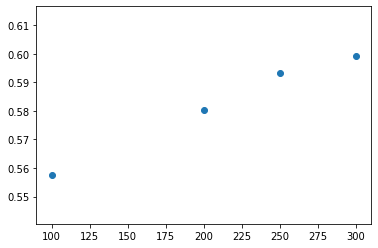

In [371]:
plt.scatter(model_comparison_df.n_components, model_comparison_df.f1_micro_avg);


As more components exist there are better results, but, on the other hand, the relative gain descends and performance time gets higher. 
We need to get a compromise between execution time and results, and I think the best option is 250 components, but due to time consumption we´ll do all next tests with 100 dimensions, doing a final test with 250

#### 3.3. <a class="anchor" id="ML_kernel">Get the best kernel
I´m going to use grid search to find the best kernel and then try to improve it. 

In [43]:
y = df[['medical_help','water','food','clothing','missing_people','electricity']]
X = df['msg_clean'].astype('str')

In [56]:
start_time = time.time()

texts = df['msg_clean'].astype('str')
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)
y = df[['medical_help','water','food','clothing','missing_people','electricity']]

X = tfidf_vectorizer.fit_transform(texts) #features

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)
X = lsa.fit_transform(X)

exec_time = round((time.time() - start_time)/60,2)
print(exec_time,"mins")

0.09 mins


In [60]:
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(SVC()))
])

start_time = time.time()
#SVC
kernel =  ['linear', 'poly', 'rbf']
# gammas = [0.1]
# penalty = ['l2','l1']
# alpha = [1e-6, 1e-3, 1e-1, 1e0]
# max_iter = [5, 1000, 10000]
# tol = [None, 1e-3]
# eta0 = [0.1, 0.001]

random_state = [3]

clf = MultiOutputClassifier(SVC())


params = {'clf__estimator__kernel': kernel}

# cv = GridSearchCV(MultiOutputClassifier(SVC()), param_grid=params)
cv = GridSearchCV(pipeline, param_grid=params)

cv.fit(X, y)
exec_time = round((time.time() - start_time)/60,2)
print(exec_time,"mins")

19.16 mins


In [61]:
print("\nBest Parameters:", cv.best_params_)


Best Parameters: {'clf__estimator__kernel': 'rbf'}


In [62]:
cv.cv_results_

{'mean_fit_time': array([24.55321865, 72.85069952, 78.05022955]),
 'std_fit_time': array([ 1.79831467,  7.89592028, 11.90508962]),
 'mean_score_time': array([ 4.3629045 ,  7.89175096, 10.51993952]),
 'std_score_time': array([0.31107438, 0.37554641, 0.81905384]),
 'param_clf__estimator__kernel': masked_array(data=['linear', 'poly', 'rbf'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__estimator__kernel': 'linear'},
  {'clf__estimator__kernel': 'poly'},
  {'clf__estimator__kernel': 'rbf'}],
 'split0_test_score': array([0.7921434 , 0.7791762 , 0.78832952]),
 'split1_test_score': array([0.92427999, 0.89586115, 0.92065611]),
 'split2_test_score': array([0.78733549, 0.78447454, 0.79267595]),
 'split3_test_score': array([0.77875262, 0.77894335, 0.79191303]),
 'split4_test_score': array([0.75433912, 0.76158688, 0.77207706]),
 'mean_test_score': array([0.80737013, 0.80000842, 0.81313033]),
 'std_test_score': array([0.05988724, 0

The best kernel is rbf, so the best option at the moment, is SVC with 250 dimensions reduction and rbf kernel

#### 3.4. <a class="anchor" id="ML_GammaC"> Get the best Gamma and C
I´m going to use grid search to find better parameters of Gamma and C. 

In [67]:
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(SVC(kernel = 'rbf', random_state = 3 )))
])

start_time = time.time()

gammas = [0.1, 1, 10]
cs = [0.1, 1, 10]



params = {'clf__estimator__gamma': gammas,
         'clf__estimator__C': cs}

cv = GridSearchCV(pipeline, param_grid=params)

cv.fit(X, y)
exec_time = round((time.time() - start_time)/60,2)
print(exec_time,"mins")

113.68 mins


In [68]:
print("\nBest Parameters:", cv.best_params_)


Best Parameters: {'clf__estimator__C': 10, 'clf__estimator__gamma': 1}


In [69]:
cv.cv_results_

{'mean_fit_time': array([ 35.79060836,  36.74275794,  59.83446417,  34.21952448,
         39.66700563,  92.39224119,  45.53900027,  45.40631652,
        147.11864271]),
 'std_fit_time': array([ 3.81360972,  2.66637492,  7.03543014,  2.25386384,  1.76775879,
        13.86148152,  3.24161962,  2.92746236, 17.77885043]),
 'mean_score_time': array([  7.10308452,   7.08826251,  10.12737212,   6.55986166,
          6.77412734, 749.13589907,   7.08155861,   6.99137878,
         11.41080394]),
 'std_score_time': array([7.35019520e-01, 4.27946572e-01, 8.21485301e-01, 4.22681151e-01,
        3.71091638e-01, 1.47620377e+03, 4.36371822e-01, 3.89348741e-01,
        8.88823898e-01]),
 'param_clf__estimator__C': masked_array(data=[0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_clf__estimator__gamma': masked_array(data=[0.1, 1, 10, 0.1, 1, 10, 0.1, 1

The best are C= 10 and gamma = 1. Look that it took almost 2 hours to do the gridsearch of parameters.

So the best model is SVC with 250 parameters reduction, with kernel rbf, C =10 and gamma = 1. I´m going to test it as we did in the beginning to see the performance

#### 3.5. <a class="anchor" id="ML_Final_Model"> Final model

In [70]:
start_time = time.time()
#Creating the features (tf-idf weights) for the processed text
texts = df['msg_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)
X = tfidf_vectorizer.fit_transform(texts) #features
y = df[['medical_help','water','food','clothing','missing_people','electricity']]

lsa = TruncatedSVD(n_components=250, 
                   n_iter=10, 
                   random_state=3)
X = lsa.fit_transform(X)

exec_time = round((time.time() - start_time)/60,2)
print(exec_time,"mins")

0.18 mins


In [71]:
print (X.shape)
print(y.shape)

(26216, 250)
(26216, 6)


In [72]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model = {'SVC' : MultiOutputClassifier(SVC(kernel = 'rbf', random_state = 3, C= 10, gamma = 1))}

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .2, 
                                                    shuffle = True, 
                                                    random_state = 3)

In [73]:
def model_score(model_dict):
    start_time = time.time()
    model_name,  f1_score_list = [], []
    model_comparison_df = pd.DataFrame(columns=['model_name', 'f1_medical_help', 'f1_water', 'f1_food', 'f1_clothing', 'f1_missing_people', 'f1_electricity', 'f1_micro_avg'])       
    i = 0
    for k,v in model.items():
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True,zero_division= 0  )
        df_rep = pd.DataFrame(report)
        df_rep = df_rep[['0','1','2','3','4','5', 'micro avg']].iloc[2]
        model_comparison_df.loc[i] = [model_name[i], df_rep[0], df_rep[1], df_rep[2], df_rep[3], df_rep[4], df_rep[5], df_rep[6]]
        i = i+1
    model_comparison_df = model_comparison_df.sort_values(by='f1_micro_avg', ascending=False)
    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    return model_comparison_df
model_score(model)

Execution time: 2.55 minutes


,model_name,f1_medical_help,f1_water,f1_food,f1_clothing,f1_missing_people,f1_electricity,f1_micro_avg
0,SVC,0.306306,0.74359,0.794937,0.57971,0.0,0.283582,0.626248


The SVC with default parameters and 100 dimensions reduction score was 0.55, and with 250 dimensions was 0.59. 

Tuning the parameters we´ve been able to increase the f1 score to 0.63...Great job!!!!

### 4. <a class="anchor" id="More_steps">Further steps
Having more computational power would allow us to do a better gridsearch parameters finding and keeping more parameters. This could be made on the cloud, but it is out of the scope in this project. Also, with actual performance, we can´t try to predict the original 36 output variables.
With actual hardware (local laptop) there are still some other ways to improve the model:
- try other algorithms. SVC was the best with default parameters but other algorithm could increase the performance with the parameters tuning
- try other features. We´ve used TfidfVectorizer to extract the features from the text, but there are other options like Word2vec or Glove, that could be a good alternative
- some of the variables, like electricity, clothing,missing or medical help, are better predicted with different algorithms than SVC. If we want to priorize one of these we could change the algorithm or even divide the objective variables in groups to predict them differently



### 5. <a class="anchor" id="Model_exp">Model exportation
I extract the model to a file in case we wan to use it in other place

In [74]:
import pickle
pickle.dump(model, open('finalized_model.sav', 'wb'))